# PCA Statistical Arbitrage

(Principal Component Analysis)

(This notebook can be found on GitHub: https://github.com/rodler/quantinsti_statarb)

### Dr Tom Starke 

*Homepage: www.aaaquants.com *

*Email: tom@aaaquants.com *

*Linkedin: Dr Tom Starke *


In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 912.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.1 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting u

In [ ]:
pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint, grangercausalitytests
import matplotlib
from itertools import groupby, count
import pickle
import yfinance as yf
from dateutil.parser import parse
import datetime
from scipy.optimize import brentq 
import traceback
from google.colab import files
import quantstats as qs
%matplotlib inline

## Build PCA from Scratch

In [ ]:
stocks = yf.download('SPY,QQQ',start='2005-1-1').Close

[*********************100%***********************]  2 of 2 completed


<AxesSubplot:xlabel='Date'>

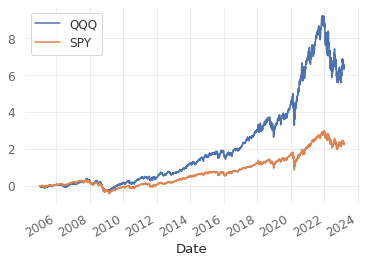

In [ ]:
stocks.pct_change().add(1).cumprod().add(-1).plot()

Fist PCA step: De-Meaning of series



In [ ]:
stocks_dem = stocks.pct_change().dropna()-stocks.pct_change().mean()

Calculate the covariance matrix of the array

In [ ]:
S = stocks_dem.cov()
S

,QQQ,SPY
QQQ,0.000191,0.000157
SPY,0.000157,0.000153


Calculate the eigenvalues and eigenvectors of the covariance matrix

In [ ]:
EIG = np.linalg.eig(S)
EIG[1]

array([[ 0.74856446, -0.66306202],
       [ 0.66306202,  0.74856446]])

Eigenvalues:

In [ ]:
print(EIG[0])

[3.29397680e-04 1.40102012e-05]


Eigenvectors:

Each eigenvector is one column of this matrix

We can see that the vectors are orthogonal to each other. This is also true for eigenvectors of higher dimensionality.

In [ ]:
evect = EIG[1]

Plotting the eigenvectors:

First, we create some x-values from the array R containing our time series.

In [ ]:
xx = np.linspace(np.nanmin(stocks_dem.SPY),np.nanmax(stocks_dem.SPY),200)

In [ ]:
dx1 = evect[0,0]
dy1 = evect[1,0]
slope1 = dy1 / dx1

dx2 = evect[0,1]
dy2 = evect[1,1]
slope2 = dy2 / dx2

In [ ]:
yy1 = slope1 * xx
yy2 = slope2 * xx

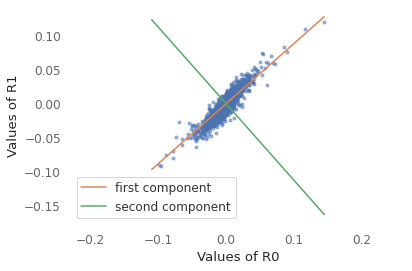

In [ ]:
# Plot de-meaned x - y correlation
plt.plot(stocks_dem.SPY,stocks_dem.QQQ,'.',alpha=0.5)

# Plot the first principal component
plt.plot(xx,yy1,label='first component')

# Plot the second principal component
plt.plot(xx,yy2,label='second component')

plt.legend()

plt.xlabel('Values of R0')

plt.ylabel('Values of R1')

plt.grid()

plt.axis('equal');

Difference between OLS and PCA:

OLS minimizies squared residuals parallel to the axis while PCA minimizes residuals orthogonal to eigenvectors.



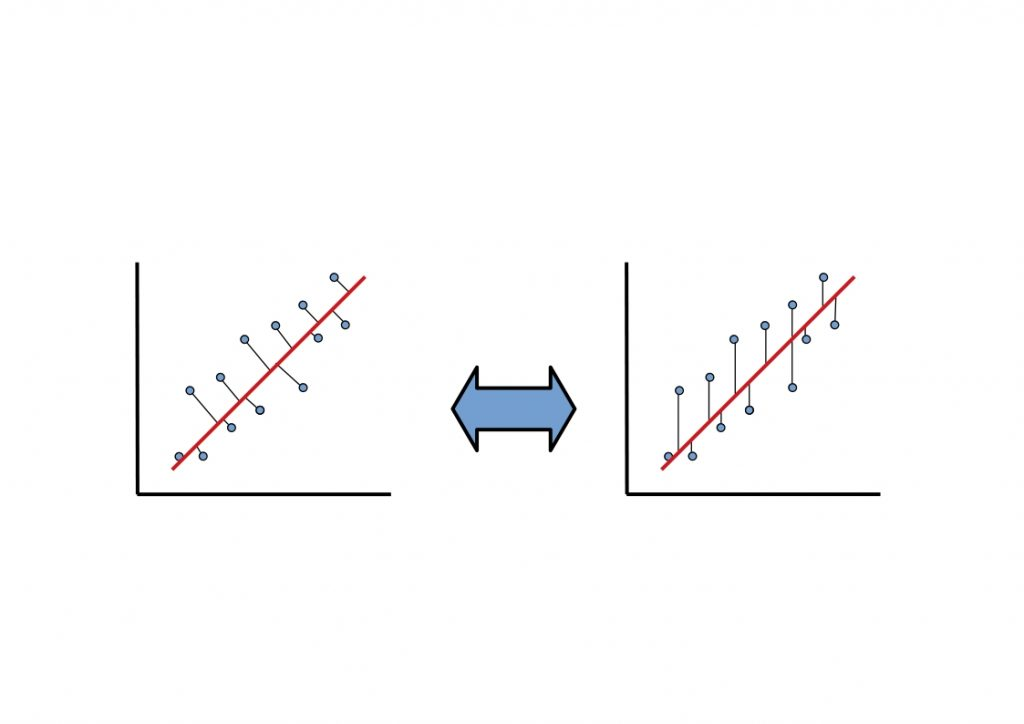

OLS does not give exactly the inverse slope if x and y axis are swapped while PCA does give the reverse slope exactly.

In [ ]:
s1 = np.polyfit(stocks_dem.SPY,stocks_dem.QQQ,1)[0]
s2 = np.polyfit(stocks_dem.QQQ,stocks_dem.SPY,1)[0]
print(s1,1/s2)

1.0253499436583282 1.2184495585519608


Downloading some more instruments for further use.

In [ ]:
stk = yf.download('GOOG,AMZN,NFLX,BAC,JPM,WFC',start='2010-1-1').Close
pair = yf.download('RB=F,CL=F',start='2010-1-1').Close

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed


Here we build a PCA funtion that returns eigenvectors in order of their "significance" based on the size of the eigenvalues.

In [ ]:
def pca(stk):
  x = stk.pct_change().dropna()
  p = np.linalg.eig((x-x.mean()).cov())
  evals = p[0]
  evec = p[1]

  # Sorting the eigenvalues and eigenvectors
  return np.sort(evals/sum(evals))[::-1],evec[:,np.argsort(evals)[::-1]]

evals,evec = pca(stk)

"Explained variance" tells us how many principal components we need to explain x% of the variance in the data set.

Text(0, 0.5, 'explained variance')

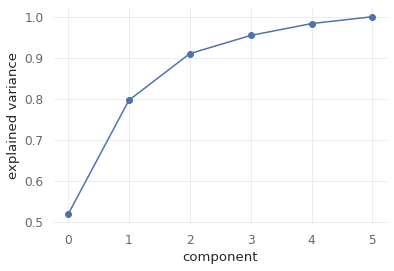

In [ ]:
"""Explained Variance"""

plt.plot(np.cumsum(evals),'-o')
plt.xlabel('component')
plt.ylabel('explained variance')

We can use PCA to find "hidden" factors or clustering in the data.

Here we can see that by plotting the first two prinicpal components of the returns for different products we can clearly distinguish between technology stocks (blue), banking stocks (green) and oil-based commodities (red).

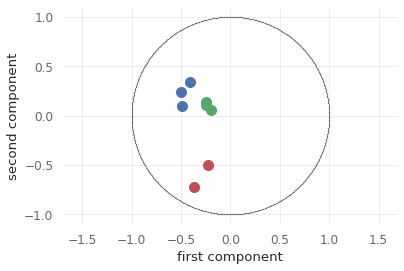

In [ ]:
"""Factor Analysis"""
r = []

lkbk = 50
r.append(pair['CL=F'].pct_change().iloc[-lkbk:].values)
r.append(pair['RB=F'].pct_change().iloc[-lkbk:].values)

r.append(stk['GOOG'].pct_change().iloc[-lkbk:].values)
r.append(stk['AMZN'].pct_change().iloc[-lkbk:].values)
r.append(stk['NFLX'].pct_change().iloc[-lkbk:].values)

r.append(stk['JPM'].pct_change().iloc[-lkbk:].values)
r.append(stk['WFC'].pct_change().iloc[-lkbk:].values)
r.append(stk['BAC'].pct_change().iloc[-lkbk:].values)

R = np.array(r)

evs = np.linalg.eig(np.cov(R-np.mean(R)))

c=['r']*2 + ['b']*3 + ['g']*3
for j,i in enumerate(evs[1]):
  plt.plot(i[0],i[1],'o',c=c[j],ms=10)

for i in np.linspace(-np.pi,np.pi,1000):
  plt.plot(np.cos(i),np.sin(i),'k.',ms=0.3)


plt.axis('equal');
plt.xlabel('first component')
plt.ylabel('second component');

## Cointegration

### Short recap: cointegration versus correlation

- Cointegrated price series do not necessarily have to be correlated and vice-versa 

- Drunk and her dog: https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction

- Same behaviour in the markets and causality relationships change. For more information please refer to Engle-Granger causality (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjcvKPcsqDeAhXTbCsKHTmNAe8QFjAAegQIBxAB&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGranger_causality&usg=AOvVaw1mYq3HhcjsVNJ9zJ6zgqdV)

Adjusting for volatility, the RBOB gasoline vs Crude Oil pair seem to be highly cointegrated.

<AxesSubplot:xlabel='Date'>

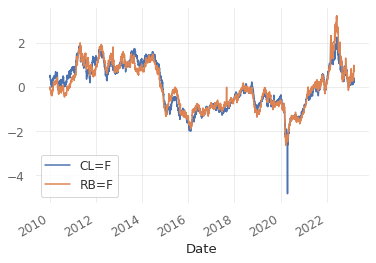

In [ ]:
((pair-pair.mean())/pair.std()).plot()

Let's run the Granger cointegration test. The first component gives us the t-statisic, the second component is the p-value of the t-statistic and the the third component are the critical values of the t-statistic for the 99%, 95% and 90% confidence level.

(-5.178658155633838, 7.625922909045838e-05, array([-3.8997438 , -3.33797212, -3.04572849]))


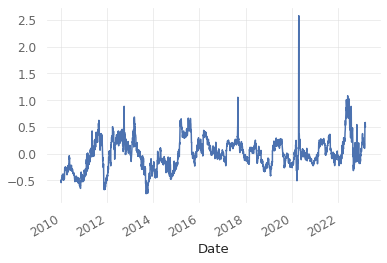

In [ ]:
spread = ((pair-pair.mean())/pair.std()).dropna()
spread.diff(axis=1)['RB=F'].plot()
print(coint(spread['RB=F'],spread['CL=F']))

The Engel-Granger causality test tells us the direction of causality in our data. There are for directions of causality, here explained with the drunk and dog analogy:
- Drunk owns dog but no leash, leads dog
- Big dog on leash lead drunk
- Small dog on leash (drunk and dog may lead)
- Dog not owned by drunk (no-one leads)

Here we can clearly see that price of Crude strongly leads the price of RBOB gasoline.

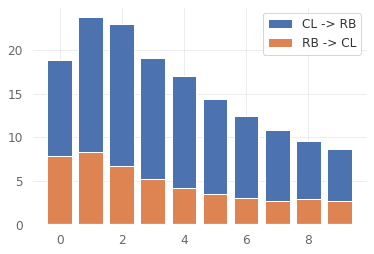

In [ ]:
X = pair['CL=F'].ffill()
Y = pair['RB=F'].ffill()

lags = 10

# Calculating the EG-Test in one direction
result = grangercausalitytests(np.array([X,Y]).T, lags, verbose=False)

# Extracting results
res_fwd = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

# Calculating the EG-Test in reverse direction
result = grangercausalitytests(np.array([Y,X]).T, lags, verbose=False)

# Extracting results
res_rev = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

plt.bar(range(lags),res_fwd,label='CL -> RB')
plt.bar(range(lags),res_rev,label='RB -> CL')
plt.legend()

Now we can backtest the Crude/RBOB spread. Futures have a dollar value associated with each tick. In this example, for simplicity, we assume the tick value is equal to the dollar value.

***This is for demonstration purposes only, do not attempt to trade this!***

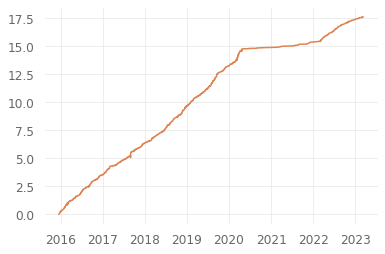

In [ ]:
inpos = 0
pnls = []
unrlzd = []
dt = []
dates = []
th = .01
comms = 0.0

# Looping through each time step
for i in range(1500,len(pair)):
  if not inpos:

    # Running the PCA
    evals,evec = pca(pair.iloc[:i])

    # Extracting the first principal component
    wgts = evec[:,0]

  # Calculating the spread based on weights
  spread = (pair*wgts).diff().values[:,1]

  # Calculating the unrealized PnL based on position
  unrlzd.append((spread[i]-spread[i-1])*inpos)
  dt.append(pair.index[i])

  # Short entry condition when spread exceeds threshold
  if not inpos and spread[i]>th:
    inpos=-1
    entry = spread[i]

  # Short exit conditions, spread goes below zero
  elif inpos<0 and spread[i]<0:

    # Adding trading costs
    unrlzd[-1]-=comms
    inpos = 0
  
  # Long entry condition when spread goes below threshold
  elif not inpos and spread[i]<-th:
    inpos=1
    entry = spread[i]

  # long exit conditions, spread exceeds zero  
  elif inpos>0 and spread[i]>0:
    unrlzd[-1]-=comms
    inpos = 0

# Plotting the results
plt.plot(dates,np.cumsum(pnls),'o')
plt.plot(dt,np.cumsum(unrlzd))

## Index arbitrage

We copy a list from the top S&P500 components from a website and extract the tickers:
https://topforeignstocks.com/indices/components-of-the-sp-500-index/

In [ ]:
q="""Apple Inc.	AAPL	Information Technology
2	Microsoft Corporation	MSFT	Information Technology
3	Amazon.com Inc.	AMZN	Consumer Discretionary
4	Berkshire Hathaway Inc. Class B	BRK.B	Financials
5	Alphabet Inc. Class A	GOOGL	Communication Services
6	UnitedHealth Group Incorporated	UNH	Health Care
7	Alphabet Inc. Class C	GOOG	Communication Services
8	Johnson & Johnson	JNJ	Health Care
9	Exxon Mobil Corporation	XOM	Energy
10	JPMorgan Chase & Co.	JPM	Financials
11	NVIDIA Corporation	NVDA	Information Technology
12	Procter & Gamble Company	PG	Consumer Staples
13	Visa Inc. Class A	V	Information Technology
14	Home Depot Inc.	HD	Consumer Discretionary
15	Tesla Inc	TSLA	Consumer Discretionary
16	Chevron Corporation	CVX	Energy
17	Mastercard Incorporated Class A	MA	Information Technology
18	Eli Lilly and Company	LLY	Health Care
19	Pfizer Inc.	PFE	Health Care
20	AbbVie Inc.	ABBV	Health Care
21	Merck & Co. Inc.	MRK	Health Care
22	Meta Platforms Inc. Class A	META	Communication Services
23	PepsiCo Inc.	PEP	Consumer Staples
24	Coca-Cola Company	KO	Consumer Staples
25	Bank of America Corp	BAC	Financials
26	Broadcom Inc.	AVGO	Information Technology
27	Thermo Fisher Scientific Inc.	TMO	Health Care
28	Costco Wholesale Corporation	COST	Consumer Staples
29	Walmart Inc.	WMT	Consumer Staples
30	Cisco Systems Inc.	CSCO	Information Technology
31	McDonald's Corporation	MCD	Consumer Discretionary
32	Abbott Laboratories	ABT	Health Care
33	Danaher Corporation	DHR	Health Care
34	Accenture Plc Class A	ACN	Information Technology
35	NextEra Energy Inc.	NEE	Utilities
36	Verizon Communications Inc.	VZ	Communication Services
37	Linde plc	LIN	Materials
38	Walt Disney Company	DIS	Communication Services
39	Wells Fargo & Company	WFC	Financials
40	Adobe Incorporated	ADBE	Information Technology
41	Philip Morris International Inc.	PM	Consumer Staples
42	Bristol-Myers Squibb Company	BMY	Health Care
43	Comcast Corporation Class A	CMCSA	Communication Services"""

stk_list = []
for  string in q.split():
  if all(l.isupper() for l in string) and len(string)>2 and len(string)<5:
    stk_list.append(string)

Now we can download the price data for those tickers

In [ ]:
np.random.shuffle(stk_list)
tickers = ",".join(stk_list)
top40 = yf.download(tickers,start='2010-1-1').Close.dropna()

[*********************100%***********************]  33 of 33 completed


Here we plot them:

<AxesSubplot:xlabel='Date'>

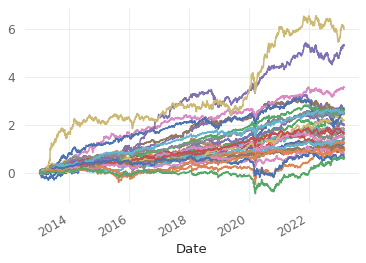

In [ ]:
top40.pct_change().cumsum().plot(legend=False)

Next, we can create an eigen-porfolio using the first principal component as weights.

In [ ]:
top40


,AAPL,ABBV,ABT,ACN,ADBE,AMZN,AVGO,BAC,BMY,COST,...,NEE,NVDA,PEP,PFE,TMO,TSLA,UNH,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,19.608213,35.119999,32.049999,69.059998,38.340000,12.865500,32.540001,12.030000,32.709999,101.449997,...,17.629999,3.180000,69.330002,24.582542,65.000000,2.357333,54.540001,35.049999,69.239998,88.709999
2013-01-03,19.360714,34.830002,33.270000,68.809998,37.750000,12.924000,32.709999,11.960000,33.240002,102.489998,...,17.632500,3.182500,69.360001,24.525618,64.800003,2.318000,51.990002,34.759998,68.800003,88.550003
2013-01-04,18.821428,34.389999,33.070000,69.190002,38.130001,12.957500,32.500000,12.110000,33.349998,102.160004,...,17.719999,3.287500,69.459999,24.629980,65.370003,2.293333,52.090000,34.939999,69.059998,88.959999
2013-01-07,18.710714,34.459999,33.340000,68.889999,37.939999,13.423000,32.320000,12.090000,33.400002,101.370003,...,17.637501,3.192500,69.449997,24.648956,65.879997,2.289333,52.090000,34.770000,68.400002,87.930000
2013-01-08,18.761070,33.709999,33.349998,69.290001,38.139999,13.319000,32.099998,11.980000,33.490002,101.180000,...,17.825001,3.122500,69.660004,24.686907,65.470001,2.245333,51.400002,34.709999,68.589996,88.480003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,153.830002,155.279999,102.750000,269.630005,347.019989,93.750000,632.919983,34.090000,68.900002,483.079987,...,74.400002,235.539993,173.500000,41.110001,558.520020,193.809998,480.779999,46.630001,140.649994,113.809998
2023-03-07,151.600006,152.929993,99.980003,264.200012,344.799988,93.550003,625.150024,33.000000,68.000000,485.149994,...,73.750000,232.880005,172.639999,40.340000,548.830017,187.710007,473.880005,44.450001,139.250000,111.610001
2023-03-08,152.869995,149.600006,99.400002,263.660004,345.839996,93.919998,632.260010,32.560001,67.290001,486.040009,...,74.250000,241.809998,173.110001,40.119999,554.750000,182.000000,470.600006,43.840000,138.100006,109.980003


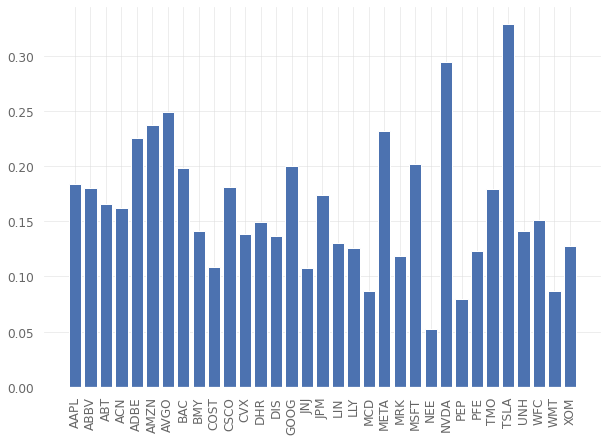

In [ ]:
split = -800
evals,evec = pca(top40.iloc[:split])
eigportf = (top40.pct_change().mul(evec[:,0])).sum(axis=1).cumsum()
index = stocks.loc[eigportf.index[0]:].SPY.pct_change().cumsum().ffill()

plt.figure(figsize=[10,7])
plt.bar(top40.columns,evec[:,0])
plt.xticks(rotation=90);

<AxesSubplot:xlabel='Date'>

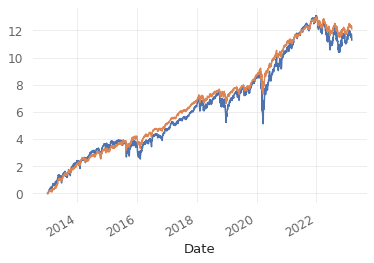

In [ ]:
index.mul(10).plot()
eigportf.mul(1).plot()

We can see that there is a strong correlation between our eigenporfolio and the SPY ETF.

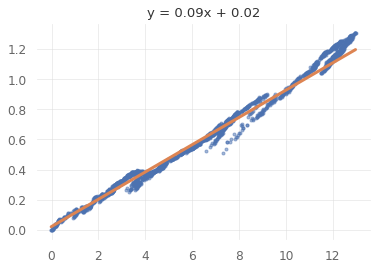

In [ ]:
plt.plot(eigportf,index,'.',alpha=0.5)
m = np.polyfit(eigportf.iloc[1:split],index.iloc[1:split],1)
xx = np.linspace(eigportf.min(),eigportf.max(),100)
yy = np.polyval(m,xx)
plt.plot(xx,yy,lw=3)
plt.title(f'y = {m[0]:.2f}x + {m[1]:.2f}');

The portfolio also looks strongly mean reverting.

<AxesSubplot:xlabel='Date'>

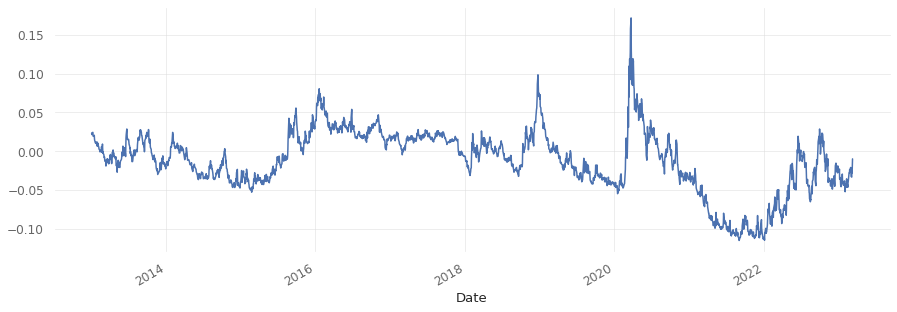

In [ ]:
(eigportf*m[0]+m[1]-index).plot(figsize=[15,5])

We can confirm that the pair is cointegrated at the 90% confidence level.

In [ ]:
coint(eigportf.iloc[1:]*m[0]+m[1],index.iloc[1:])

(-3.5269815663126574,
 0.03007732108974873,
 array([-3.90071818, -3.338515  , -3.04610519]))

In [ ]:
resid = eigportf*m[0]+m[1]-index

In [ ]:
inpos = 0
pnls = []
bw = .2
unrlzd = []
dates = []
pdates = []
for i,p in enumerate(resid):
  if i>100:
    unrlzd.append((p-resid.iloc[i-1])*inpos)
    dates.append(resid.index[i])

    #"""Long Side"""
    if not inpos and p<resid.iloc[:i].std()*bw:
      entry = p
      inpos = 1
    elif inpos==1 and p>0:
      pnl = p-entry
      pnls.append(pnl)
      pdates.append(resid.index[i])
      inpos = 0

    #"""Short Side"""
    elif not inpos and p>resid.iloc[:i].std()*bw:
      entry = p
      inpos = -1
    elif inpos==-1 and p<0:
      pnl = entry-p
      pnls.append(pnl)
      pdates.append(resid.index[i])
      inpos = 0

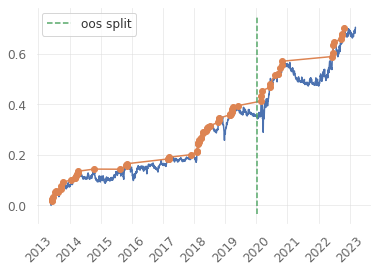

In [ ]:
plt.plot(dates,np.cumsum(unrlzd),'-')
plt.plot(pdates,np.cumsum(pnls),'-o')
plt.xticks(rotation=45)
xmin,xmax,ymin,ymax = plt.axis()
plt.plot([resid.index[split]]*2,[ymin,ymax],'--',label='oos split')
plt.legend()